# Demonstrate a working controller

## 1. Set up the notebook

Do imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, IFrame, HTML
from ae483tools import *

Define a function to check mocap data from a given flight.

In [2]:
def check_data(filename):
    # Load data
    raw_data_drone, raw_data_mocap = load_hardware_data(filename)

    # Compute statistics
    how_many_timesteps = len(raw_data_mocap['z'])
    how_many_dropouts = len(np.argwhere(np.isnan(raw_data_mocap['z'])).flatten())
    percent_coverage = 100. * (1. - (how_many_dropouts / how_many_timesteps))
    elapsed_time = raw_data_mocap['time'][-1] - raw_data_mocap['time'][0]
    sample_rate = how_many_timesteps / elapsed_time

    # Plot data (with relevant statistics in the title)
    fig, ax = plt.subplots(1, 1, figsize=(7, 3), tight_layout=True)
    ax.plot(raw_data_mocap['time'], raw_data_mocap['z'])
    ax.set_xlabel('t (seconds)')
    ax.set_ylabel('z (meters)')
    ax.set_ylim(0., 1.)
    ax.set_title(f'({filename}) Tracked {percent_coverage:.1f}% of {how_many_timesteps} time steps at about {sample_rate:.0f} Hz')
    ax.grid()

Define a function to embed videos that have been uploaded to [Illinois Mediaspace](https://mediaspace.illinois.edu/).

In [3]:
def mediaspace(url, width=640, height=397):
    video_id = url.rsplit('/', 1)[-1]
    src = f'https://mediaspace.illinois.edu/embed/secure/iframe/entryId/{video_id}?st=0'
    display(IFrame(src, width=width, height=height))
    display(HTML(f'<a href="{url}" target="_blank">Go to video on Illinois Mediaspace</a>'))

## 2. Check mocap coverage

Check `demonstration_data.json`.

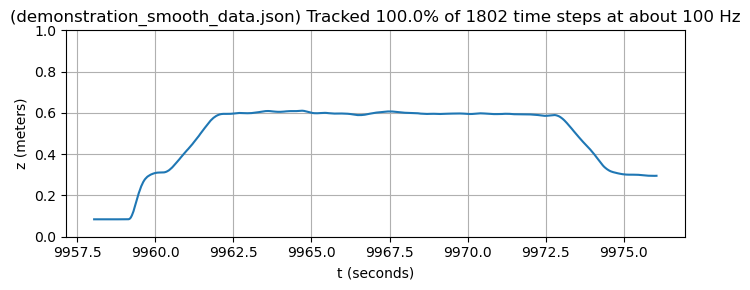

In [4]:
check_data('demonstration_smooth_data.json')

## 3. Show results

Load flight data.

In [5]:
raw_data_drone, raw_data_mocap = load_hardware_data('demonstration_smooth_data.json')

Resample and parse drone data.

In [19]:
data_drone = resample_data_drone(
    raw_data_drone,
    t_min_offset=0., # <-- FIXME
    t_max_offset=0., # <-- FIXME
)

# data_mocap = resample_data_mocap(raw_data_mocap, data_drone['time'], 0.5)



# time
t = data_drone['time']

# position
p_x = data_drone['ae483log.p_x']
p_y = data_drone['ae483log.p_y']
p_z = data_drone['ae483log.p_z']

data_mocap = sync_data_mocap(raw_data_mocap, t, p_z)

only_in_flight(data_drone, data_mocap, t_interval=12.)

# time
t = data_drone['time']

# position
p_x = data_drone['ae483log.p_x']
p_y = data_drone['ae483log.p_y']
p_z = data_drone['ae483log.p_z']

# desired position
p_x_des = data_drone['ae483log.p_x_des']
p_y_des = data_drone['ae483log.p_y_des']
p_z_des = data_drone['ae483log.p_z_des']

# orientation
psi = data_drone['ae483log.psi']
theta = data_drone['ae483log.theta']
phi = data_drone['ae483log.phi']

# motor power commands
m_1 = data_drone['ae483log.m_1']
m_2 = data_drone['ae483log.m_2']
m_3 = data_drone['ae483log.m_3']
m_4 = data_drone['ae483log.m_4']

Resample and parse mocap data (with an optimal time shift and with coordinate transformation).

In [20]:
p_x_mocap = data_mocap['x']
p_y_mocap = data_mocap['y']
p_z_mocap = data_mocap['z']
psi_mocap = data_mocap['yaw']
theta_mocap = data_mocap['pitch']
phi_mocap = data_mocap['roll']

Plot $x, y$ data.

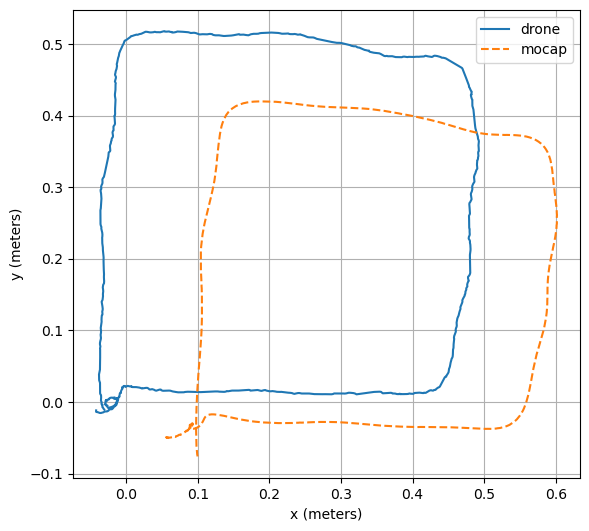

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)
ax.plot(p_x, p_y, label='drone')
ax.plot(p_x_mocap, p_y_mocap, '--', label='mocap')
ax.set_aspect('equal')
ax.set_xlabel('x (meters)')
ax.set_ylabel('y (meters)')
ax.legend()
ax.grid()

Plot all data.

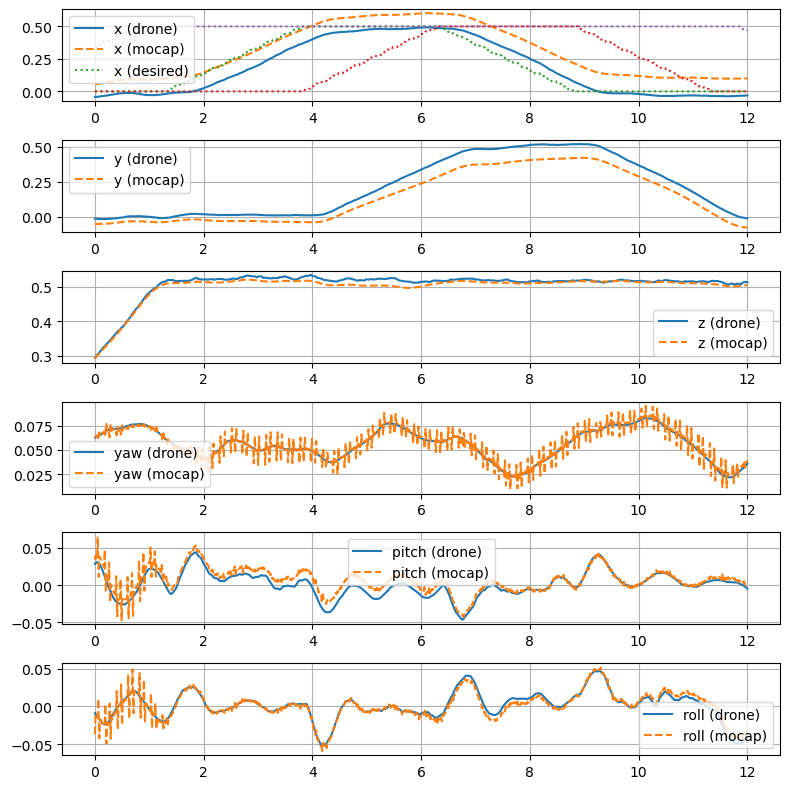

In [22]:
fig, (ax_x, ax_y, ax_z, ax_psi, ax_theta, ax_phi) = plt.subplots(6, 1, figsize=(8, 8), tight_layout=True)

ax_x.plot(t, p_x, label='x (drone)')
ax_x.plot(t, p_x_mocap, '--', label='x (mocap)')
ax_x.plot(t, p_x_des, ':', label='x (desired)')
ax_x.legend()
ax_x.grid()

ax_y.plot(t, p_y, label='y (drone)')
ax_y.plot(t, p_y_mocap, '--', label='y (mocap)')
ax_x.plot(t, p_y_des, ':', label='y (desired)')
ax_y.legend()
ax_y.grid()

ax_z.plot(t, p_z, label='z (drone)')
ax_z.plot(t, p_z_mocap, '--', label='z (mocap)')
ax_x.plot(t, p_z_des, ':', label='z (desired)')
ax_z.legend()
ax_z.grid()

ax_psi.plot(t, psi, label='yaw (drone)')
ax_psi.plot(t, psi_mocap, '--', label='yaw (mocap)')
ax_psi.legend()
ax_psi.grid()

ax_theta.plot(t, theta, label='pitch (drone)')
ax_theta.plot(t, theta_mocap, '--', label='pitch (mocap)')
ax_theta.legend()
ax_theta.grid()

ax_phi.plot(t, phi, label='roll (drone)')
ax_phi.plot(t, phi_mocap, '--', label='roll (mocap)')
ax_phi.legend()
ax_phi.grid()

In the following cell, show a video of your hardware flight test (change the url as appropriate).

In [ ]:
# FIXME (REPLACE URL TO SHOW A VIDEO OF YOUR FLIGHT)
mediaspace('https://mediaspace.illinois.edu/media/t/YOUR_VIDEO_ID')

**Modify this cell** to describe three things:

* Your design.
* Your flight test.
* Your results, in particular making clear if these results satisfy requirements. (Feel free to add code to verify these requirements.)

### RMSEs

In [23]:
def flight_rmse(data_drone, data_mocap):
    data_labels = ["ae483log.p_x", "ae483log.p_y", "ae483log.p_z", "ae483log.psi", "ae483log.theta", "ae483log.phi"]
    mocap_labels = ["x", "y", "z", "yaw", "pitch", "roll"]
    data_desired = ["ae483log.p_x_des", "ae483log.p_y_des", "ae483log.p_z_des"]

    drone_nums = np.array([data_drone[data_label] for data_label in data_labels])
    mocap_nums = np.array([data_mocap[data_label] for data_label in mocap_labels])
    desired_vals = np.array([data_drone[desired_val] for desired_val in data_desired])
    desired_vals = np.vstack([desired_vals, np.zeros(desired_vals.shape)])

    rmse_drone = np.array([np.sqrt(np.mean((drone_nums[i] - desired_vals[i])**2)) for i in range(len(data_labels))])
    rmse_mocap = np.array([np.sqrt(np.mean((mocap_nums[i] - desired_vals[i])**2)) for i in range(len(data_labels))])

    return rmse_drone, rmse_mocap

In [24]:
rmse_drone, rmse_mocap = flight_rmse(data_drone, data_mocap)

rmse_drone_strings = [f"{this_rmse:.3f} | " for this_rmse in rmse_drone]
rmse_mocap_strings = [f"{this_rmse:.3f} | " for this_rmse in rmse_mocap]
results_str = "| Drone data | " + "".join(rmse_drone_strings) + "\n| Mocap data | " + "".join(rmse_mocap_strings)

print(results_str)

| Drone data | 0.069 | 0.061 | 0.024 | 0.058 | 0.016 | 0.018 | 
| Mocap data | 0.118 | 0.094 | 0.020 | 0.059 | 0.017 | 0.018 | 


| Data source | RMSE in $p_x$ | RMSE in $p_y$ | RMSE in $p_z$ | RMSE in $\psi$ | RMSE in $\theta$ | RMSE in $\phi$ |
| :--: | :--: | :--: | :--: | :--: | :--: | :-- |
| Drone data | 0.069 | 0.061 | 0.024 | 0.058 | 0.016 | 0.018 | 
| Mocap data | 0.118 | 0.094 | 0.020 | 0.059 | 0.017 | 0.018 | 

## 4. Reflect

The motion capture system seems to agree with the drone on $p_z$, $\psi$, $\theta$, and $\phi$ RMSE values. However, the $p_x$ and $p_y$ RMSE values differ significantly between the drone and mocap system. This makes sense, as the drone has no good way of observing motion in the $x$ and $y$ directions, while the motion capture system can detect the drone's lateral position with good accuracy.